# Analysis of Student Data for Union College Math Majors

## Part 6 - Additional data on non-majors

* Received additional data with grades in mathematics courses for all students who took MTH-199 between the 13-14 and 17-18 academic years.
  + This includes the data for majors, analyzed in parts 1-5, and adds data for non-majors.
* Cleaned new data
  + Same formating as previous data (see part 2)
  + De-identified ids will not match previous parts, but are internally consistent
  
WORKING ON  
  
* Explore
  + counts
  + check assumptions
  + distributions
  + ...
  
* Analysis
  * Major vs. non-major in MTH-199
  * How well does non-major GPA in MTH-199 predict upper level GPA
    + as compared to major - same box plot adding hue?
    
  * ...
  

### Set up the notebook environment

In [19]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import union_constants as uc

In [21]:
# Settings
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (6.0, 6.0)
pd.set_option('max_rows', 7)
pd.set_option('max_columns', 50)

In [2]:
# File names
major_data_fn = 'data/union_students_818.xlsx'
major_cleaned_fn = 'data/union_students_818_cleaned.xlsx'
all_grades_fn = 'data/MTH_199_GRADE_HISTORY.xlsx'

### Load and clean the data

In [3]:
# Load grades data
grades = pd.read_excel(all_grades_fn, sheet_name='psa.grdcrshst')

# Column name style preferences
grades.columns = map(str.lower, grades.columns)

# Load major info to figure out which IDs are for math majors
major_info = pd.read_excel(major_data_fn, usecols='A', sheet_name='student info')
major_ids = major_info['@ID'].unique()
grades['major'] = grades['id'].isin(major_ids)

In [4]:
# Compare with previous data set 
# See that assumptions about data for majors being the same holds.
# Actual ids used since the mapping was not stored. Hiden from final output.
major_grades = pd.read_excel(major_data_fn, sheet_name='psa.grad.grades')
major_grades.columns = map(str.lower, major_grades.columns)
major_grades.drop(['name', 'acad major', 'faculty'], axis=1, inplace=True)

merged_grades = (major_grades
 .merge(grades.loc[grades.major].drop('name', axis=1),
        how='outer', on=['id', 'course', 'term'], suffixes=['_old', '_new'])
 .loc[:, ['id', 'course', 'term', 'grade_old', 'grade_new']])


print('Data for math majors that only appears in one of the data sets:')

merged_grades.loc[merged_grades.grade_old.isnull() | 
                  merged_grades.grade_new.isnull()].drop('id', axis=1)


Data for math majors that only appears in one of the data sets:


,course,term,grade_old,grade_new
778,MTH-219,15/FA,B,NaN
779,MTH-336,16/FA,C,NaN
780,MTH-487,16/FA,B+,NaN
781,MTH-332,16/SP,C,NaN
782,MTH-480,16/SP,C+,NaN
783,MTH-234,16/WI,B-,NaN
784,MTH-340,16/WI,B+,NaN
785,MTH-340,16/WI,B+,NaN


* The only missing data is for a single student who did not take MTH-199

In [5]:
# De-identify ids
#   Reassign student ids to unknown student-id pairings.
#   These will be different from the pairings used in parts 2-5
unique_ids = grades['id'].unique()
np.random.shuffle(unique_ids)
new_ids = {unique_id:idx + 1 for idx, unique_id in enumerate(unique_ids)}
grades['id'] = grades.apply(lambda srs: new_ids[srs['id']], axis=1)

# Drop names
grades.drop(['name'], axis=1, inplace=True)

# Sort
grades.sort_values(['id', 'course'], inplace=True)

In [6]:
# # Check for duplicate rows
print('Any duplicate rows? {0}'.format(grades.duplicated().any()))
print()

# Display and drop MTH-000 students
print('Dropped MTH-000:')
display(grades.loc[grades.course == 'MTH-000']) 
grades.drop(grades.loc[grades.course == 'MTH-000'].index, inplace=True)

# Add year column and reassign term to season only
grades['year'] = grades['term'].map(lambda srs: int('20' + srs.split('/')[0]))
grades['term'] = grades['term'].map(lambda srs: srs.split('/')[1])

# Derive grade point columns
grades['point'] = grades['grade'].map(lambda grade: uc.grade_to_point[grade])

Any duplicate rows? False

Dropped MTH-000:


,id,term,course,grade,major
1847,129,16/SU,MTH-000,NC,True
2433,185,17/SU,MTH-000,NC,True
218,244,17/SU,MTH-000,NC,True


### Descriptive statistics

,major,count
1,True,109
0,False,263


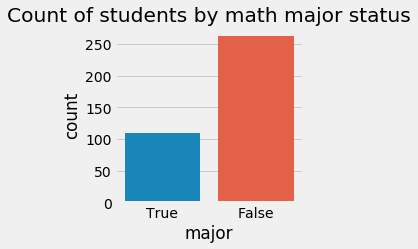

In [131]:
# Count number of majors vs. non-majors
major_count = (grades.groupby('major').apply(lambda df: len(df.id.unique()))
               .to_frame(name='count')
               .reset_index()
               .sort_values(by='major', ascending=False))

display(major_count)

plt.figure(figsize=(3, 3))
sns.barplot(data=major_count, x='major', y='count', order=[True, False])
plt.title('Count of students by math major status')
plt.show()

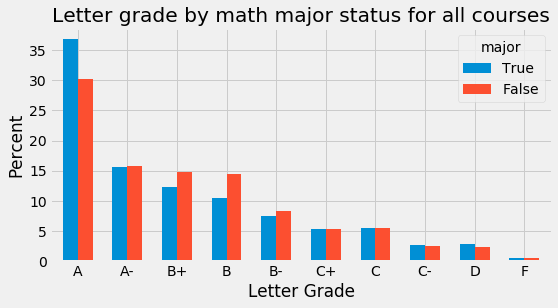

In [59]:
# Letter grade by major vs. non-major as percentage of grades from the 
# corresponding category
(grades
 .drop(grades.loc[grades.grade == 'P'].index)
 .pivot_table('id', 'major', 'grade', aggfunc=len)
 .sort_index(ascending=False)
 .reindex(columns=uc.grade_rank, fill_value=0.0)
 .apply(lambda srs: srs / sum(srs) * 100, axis=1)).T.plot.bar(figsize=(8, 4),
                                                              width=0.6)
plt.title('Letter grade by math major status for all courses')
plt.xticks(rotation=0)
plt.ylabel('Percent')
plt.xlabel('Letter Grade')
plt.show()

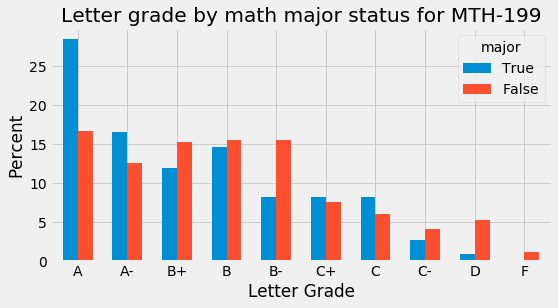

In [142]:
# Letter grade by major vs. non-major as percentage of grades from the 
# corresponding category
(grades
 .drop(grades.loc[(grades.grade == 'P') | (grades.course != 'MTH-199')].index)
 .pivot_table('id', 'major', 'grade', aggfunc=len)
 .fillna(0)
 .sort_index(ascending=False)
 .reindex(columns=uc.grade_rank, fill_value=0.0)
 .apply(lambda srs: srs / sum(srs) * 100, axis=1)).T.plot.bar(figsize=(8, 4),
                                                              width=0.6)
plt.title('Letter grade by math major status for MTH-199')
plt.xticks(rotation=0)
plt.ylabel('Percent')
plt.xlabel('Letter Grade')
plt.show()